# Chapter 3: Bayesian Inference

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad, dblquad
from scipy.optimize import minimize, fsolve, root
from scipy.stats import norm, pearsonr, t, ttest_ind
import warnings

warnings.filterwarnings("ignore")

In [2]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (20, 15)

### 3.1: Two Examples

In [3]:
url = "https://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt"
scores = pd.read_csv(url, header=0, sep=" ")

In [4]:
n = scores.shape[0]

m = scores.mech.values
mbar = np.mean(m)

v = scores.vecs.values
vbar = np.mean(v)

In [5]:
numer = np.sum((m - mbar) * (v - vbar))
denom = (np.sum((m - mbar)**2) * np.sum((v - vbar)**2))**0.5
corrcoef = numer / denom

print(
    'Pearson correlation coef (mechanics and vectors) = ' + 
    str(round(corrcoef, 3))
)

t_hat = corrcoef

Pearson correlation coef (mechanics and vectors) = 0.498


In [60]:
def likelihood(t):
    global t_hat
    integrand = lambda w: 1 / (np.cosh(w) - t * t_hat)**21
    integral = float(quad(integrand, 0, np.inf)[0])
    multiplier = (20 / np.pi) * (1 - t**2)**10.5 * (1 - t_hat**2)**9
    return multiplier * integral

In [61]:
def pflat(t):
    return float(1 / 2)

def pjeffreys(t):
    return float(1 / (1 - t**2))

def ptriangle(t):
    return float(1 - abs(t))

In [8]:
def denominator(prior):
    global t_hat
    f = lambda w, t: (
        prior(t) 
        * (20 / np.pi) 
        * (1 - t**2)**10.5 
        * (1 - t_hat**2)**9 
        * (1 / (np.cosh(w) - t * t_hat)**21)
    )
    out = dblquad(f, -1, 1, lambda t: 0, lambda t: np.inf)[0]
    return float(out)

In [104]:
t_vals = np.arange(-0.2, 1, 0.01)

In [105]:
post_flat = [(pflat(t) * likelihood(t)) / denominator(pflat) for t in t_vals]
post_jeffreys = [(pjeffreys(t) * likelihood(t)) / denominator(pjeffreys) for t in t_vals]
post_triangle = [(ptriangle(t) * likelihood(t)) / denominator(ptriangle) for t in t_vals]

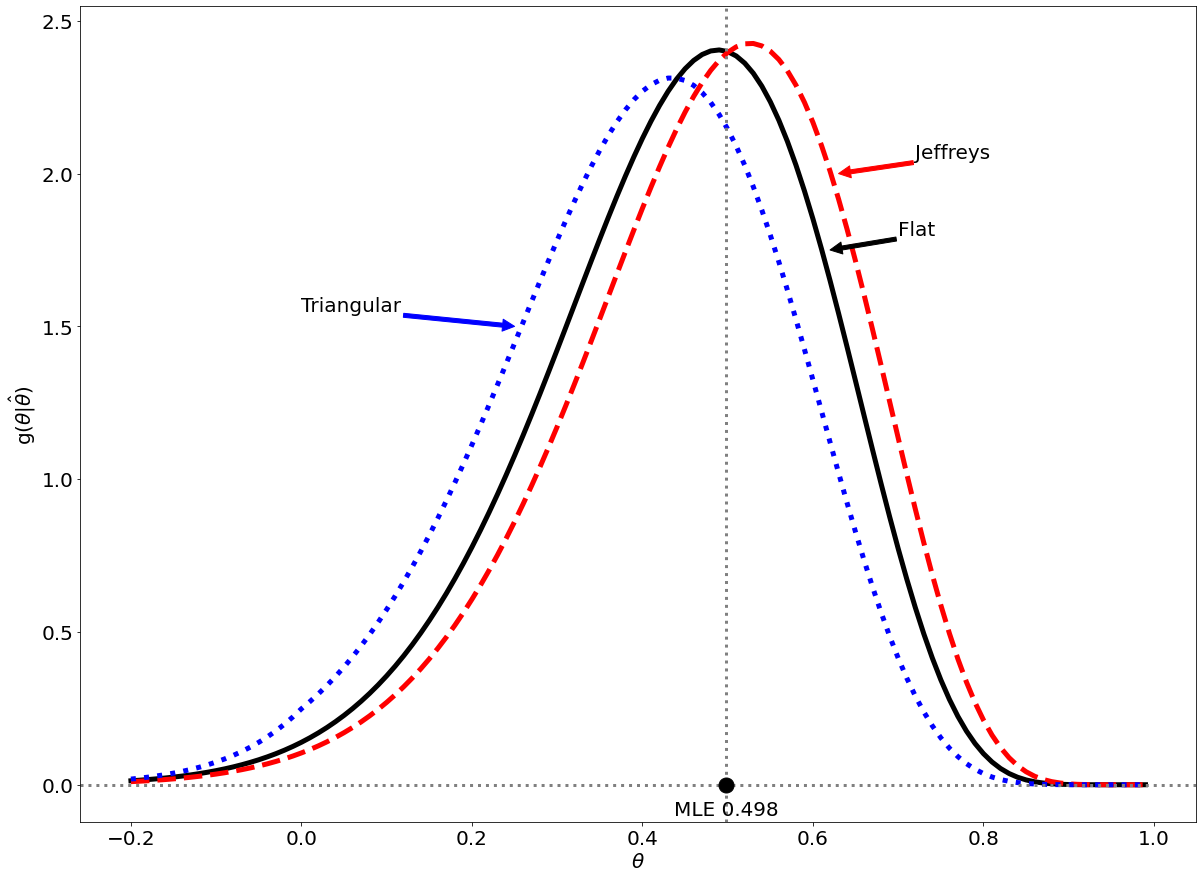

In [232]:
plt.plot(t_vals, post_flat, "-", c='k', lw=5)
plt.annotate("Flat", (0.62, 1.75), xytext=(0.7, 1.8), arrowprops=dict(color='k'))

plt.plot(t_vals, post_jeffreys, "--", c='r', lw=5)
plt.annotate("Jeffreys", (0.63, 2.0), xytext=(0.72, 2.05), arrowprops=dict(color='r'))

plt.plot(t_vals, post_triangle, ":", c='b', lw=5)
plt.annotate("Triangular", (0.25, 1.5), xytext=(0, 1.55), arrowprops=dict(color='b'))

plt.axhline(0, c="gray", ls=":", lw=3)
plt.axvline(t_hat, c="gray", ls=":", lw=3)

plt.plot([t_hat], [0], 'o', c="k", ms=15)
plt.text(t_hat, -0.1, "MLE {:.3f}".format(t_hat), 
         horizontalalignment="center", color="k")

plt.xlabel("$\\theta$")
plt.ylabel("g($\\theta$|$\\hat\\theta$)")

plt.show()

### 3.2: Uninformative Prior Distributions

In [235]:
# 0 = 0.95 - round(quad(test, a, b)[0], 2) -- solve for a and b

func1 = lambda t: (pjeffreys(t) * likelihood(t)) / denominator(pjeffreys)
func2 = lambda a, b: 0.95 - round(quad(func1, a, b)[0], 2)

0.95

### 3.3: Flaws in Frequentist Inference

In [161]:
# one-sided hypothesis test
# H_o : mu = 0
# H_a : mu > 0
# critical value for alpha = 0.05:
alpha = 0.05
critval = round(norm.ppf(1 - alpha, loc=0, scale=1), 3)
print(critval)

1.645


In [156]:
n = 30
mu = 0.
sig = 1.

# sample x values
x = np.random.normal(loc=mu, scale=sig, size=n)
# calculate z value
z = [sum(x[:i+1]) / np.sqrt(i+1) for i in range(n)]

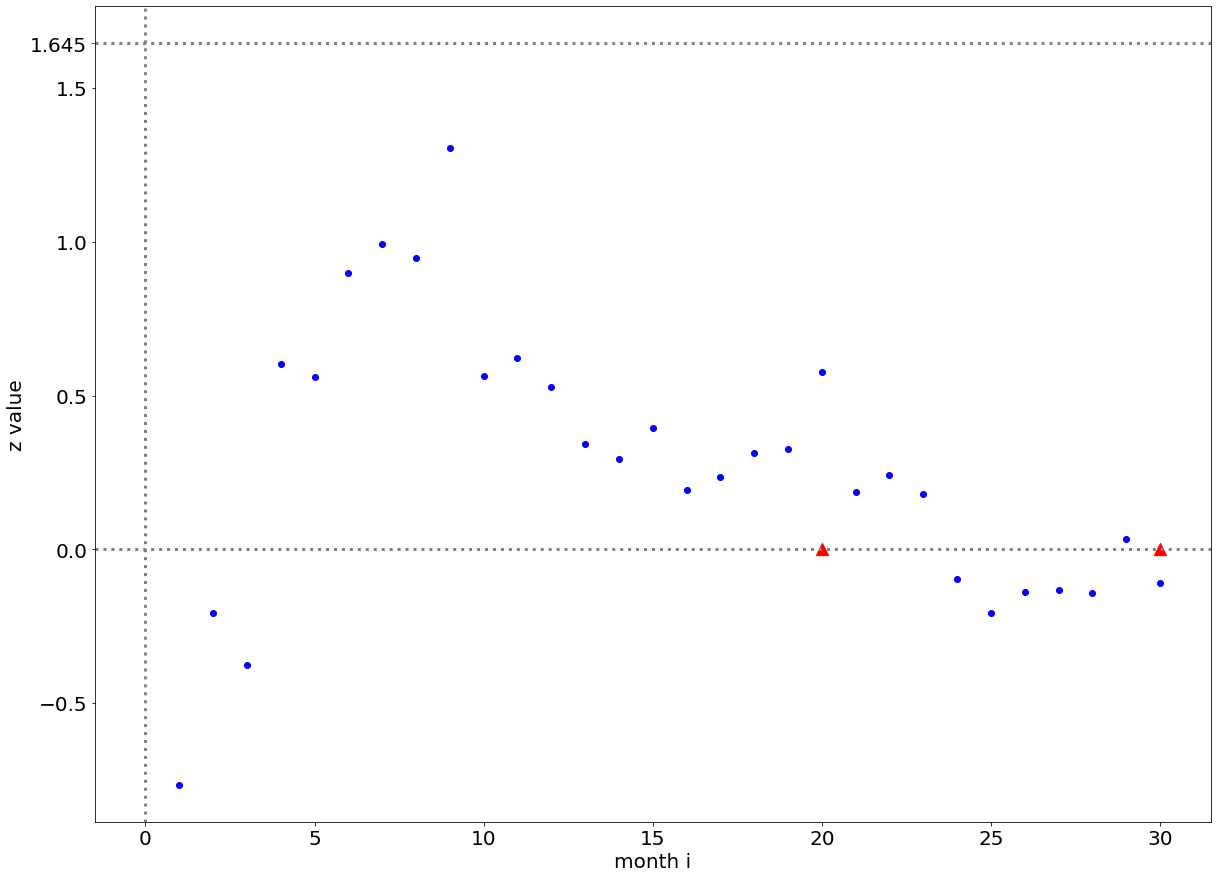

In [219]:
# plot looks different because of random sampling of x values

fig, ax = plt.subplots()

ax.plot(range(1, n+1), z, "o", c="b")

ax.axhline(0, c="gray", ls=":", lw=3)
ax.axhline(critval, c="gray", ls=":", lw=3)
ax.axvline(0, c="gray", ls=":", lw=3)

ax.scatter([20, 30], [0, 0], marker="^", s=150, c="red")

ax.set_yticks([critval], minor=True)
ax.set_yticklabels([critval], minor=True)
ax.tick_params(axis='both', which='minor', length=4)

ax.set_xlabel("month i")
ax.set_ylabel("z value")

plt.show()

In [170]:
url = "http://web.stanford.edu/~hastie/CASI_files/DATA/prostmat.csv"
df = pd.read_csv(url, header=0, sep=',')
df.head(4)

,control,control.1,control.2,control.3,control.4,control.5,control.6,control.7,control.8,control.9,...,cancer.42,cancer.43,cancer.44,cancer.45,cancer.46,cancer.47,cancer.48,cancer.49,cancer.50,cancer.51
0,-0.930895,-0.751885,-0.545781,-1.078519,-0.994677,0.015547,-0.853963,4.016860,-0.399641,-1.085050,...,-0.845358,0.936035,-0.819505,-0.849670,0.434865,2.054122,2.799498,1.294162,2.905588,3.434504
1,-0.839996,-0.848271,-0.851687,-0.159610,-0.751905,-0.516436,-0.826845,-0.832741,-0.840731,-0.824386,...,0.563857,-0.439367,2.052858,0.441992,0.675806,-0.450853,1.385720,-1.143997,-0.282119,-1.174233
2,0.062508,0.102895,-0.003043,0.215347,-1.163109,1.028130,-0.476408,-1.154759,-1.161665,-0.690671,...,-0.007371,0.629820,-1.107093,-0.968790,-0.235357,-1.049600,1.186599,0.962634,-0.026753,1.533532
3,-0.361594,2.421034,-0.122089,-0.096277,-1.130144,0.458272,0.633883,0.069708,-1.128592,-0.429663,...,-0.508988,-0.409035,0.557853,-0.900065,1.491239,0.553022,0.118476,1.220066,-1.138651,0.174831


In [178]:
df.shape

(6033, 102)

In [179]:
control_col = [c for c in df.columns if c.startswith('control')]
cancer_col = [c for c in df.columns if c.startswith('cancer')]

In [181]:
# 2-sample t-test
# unequal variance
# null distribution: t_100
# form: phi^-1(F_100(ti)) where phi is standard norm cdf and F_100 is t_100 cdf
# ppf = inverse of cdf
phi_inv = norm.ppf 
f100 = t(df=100).cdf

In [182]:
zvals = []
for idx, row in df.iterrows():
    tmp_control = row[control_col].values
    tmp_cancer = row[cancer_col].values
    ti, _ = ttest_ind(tmp_cancer, tmp_control, equal_var=False)
    zvals.append(phi_inv(f100(ti)))

In [211]:
gene = 610
x_gene = round(zvals[gene - 1], 2)
print('Value for gene {0} = {1}'.format(gene, x_gene))

Value for gene 610 = 5.29


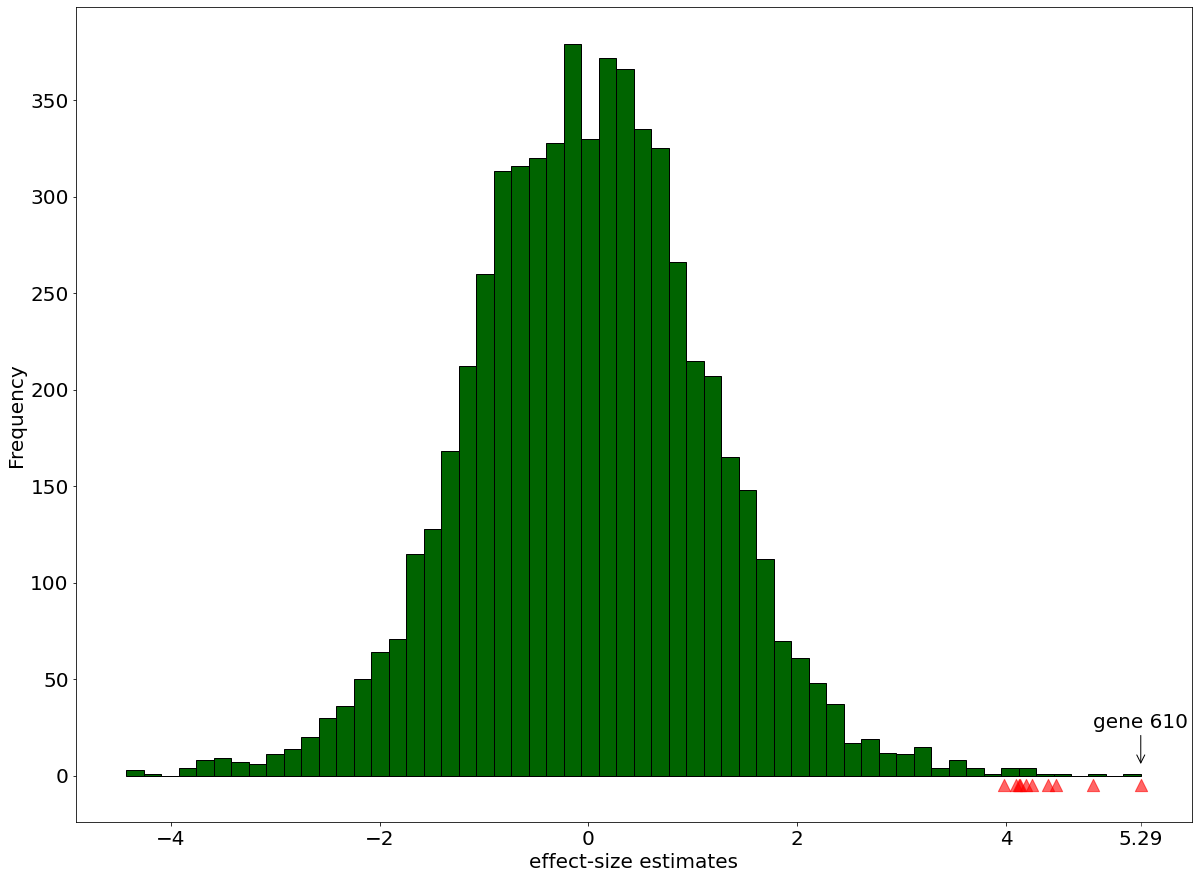

In [217]:
n_extreme = 10

fig, ax = plt.subplots()

ax.hist(zvals, bins=58, color='darkgreen', edgecolor='black')
ax.scatter(sorted(zvals)[-n_extreme:], [-5]*n_extreme, marker='^', s=150, c='red', alpha=0.6)
ax.annotate(
    "gene " + str(gene), (x_gene, 5), xytext=(x_gene, 25), 
    arrowprops=dict(arrowstyle="->", color="k"), horizontalalignment="center"
)

ax.set_xticks([x_gene], minor=True)
ax.set_xticklabels([x_gene], minor=True)
ax.tick_params(axis='both', which='minor', length=4)

ax.set_xlabel("effect-size estimates")
ax.set_ylabel("Frequency")

plt.show()